# Learning Frozen Lake problem using Q learning

In this work, we will try to learn policy for an agent using a Temporal Difference learning algorithm called **Q-Learning**.

We will create an environement of 5*5 size and add few manual hole in it for which the agent tries to reach its destination location which is at bottom right cell of the environment from the start position which is top left cell.

Also this work considers frozen lake problem as a determinsitic problem, not considering other varient of this problem known as slippery frozen lake where actions are not deterministic. In determinsitic case like ours, if we move "right" the agent always moves "right" and not to any other direction.

**Note:** We wont be using any other library to simulate environment and agents like OpenAI Gym. Rather code from scratch all the classes like Agent, States and Environment.

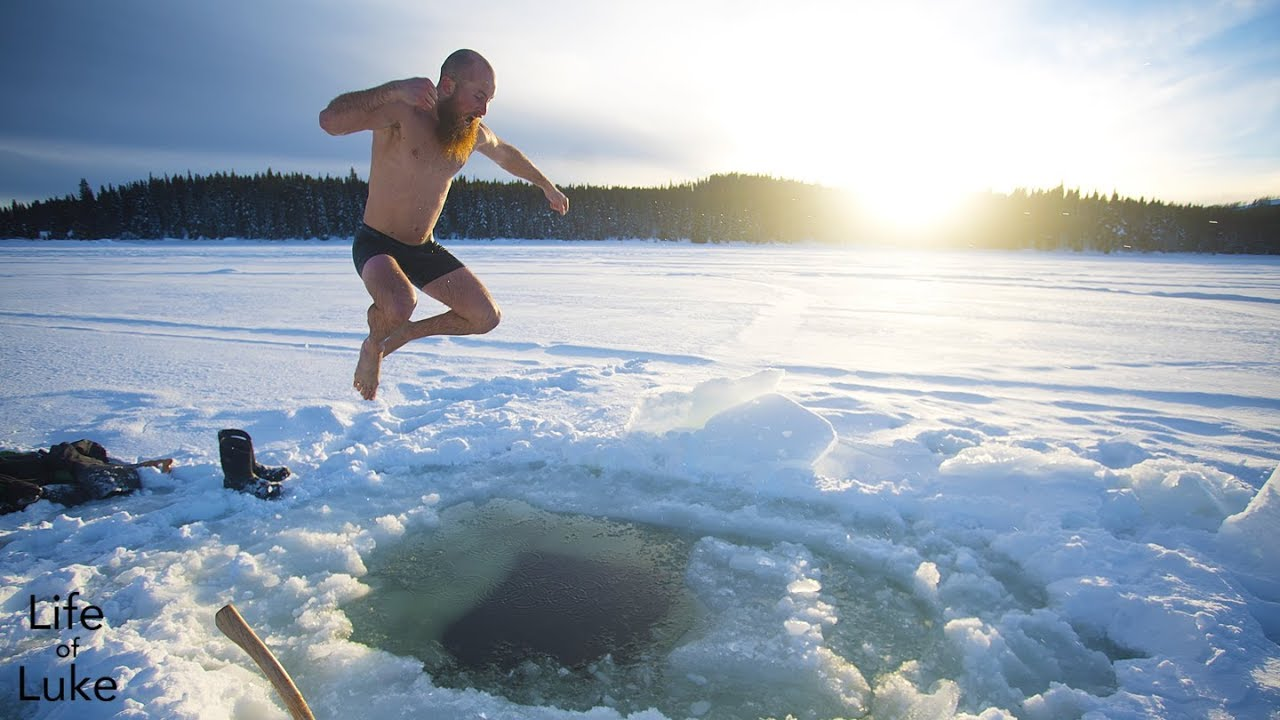

### Importing necessary libraries

In [1]:
import numpy as np
import random
import seaborn as sn
import matplotlib.pyplot as plt

### Defining global variables for environment

In [2]:
BOARD_ROWS = 5                      # Number of rows of frozen lake
BOARD_COLS = 5                      # Number of cols of frozen lake
WIN_STATE = (4, 4)                  # Agent want to reach bottom right corner
START = (0, 0)                      # Agent will start from top left corner
HOLES = [(1,0),(1,3),(3,1),(4,2)]   # Manually adding few hole in the environment

### Defining hyperparameters

In [3]:
total_episodes = 10000       # Total episodes
learning_rate = 0.5          # Learning rate
max_steps = 99               # Max steps per episode
gamma = 0.9                  # Discounting rate
epsilon = 0.1                # Exploration rate

# Uncomment bellow hyperameters to decrease exploration rate wrt time
# max_epsilon = 1.0          # Exploration probability at start
# min_epsilon = 0.01         # Minimum exploration probability 
# decay_rate = 0.005         # Exponential decay rate for exploration prob

### Defining State 

In [4]:
class State:
    def __init__(self,x,y): # Initialize state with provided coordinates
        self.cordinates = (x,y)
        self.isEnd = False
        
    def getCoordinates(self):
        return self.cordinates
        
    def getReward(self):
        if self.cordinates == WIN_STATE: # Rward at win state is 10
            return 10 
        elif self.cordinates in HOLES:   # Reward for failing in any hole is -5 ie punishment
            return -5
        else:                            # Reward for each transition to a non terminal state is -1
            return -1
    
    def isEndFunc(self):
        if (self.cordinates == WIN_STATE):
            self.isEnd = True
    
    def conversion(self):               # Function to convert a cell location (2d space) to 1d space for q learning table
        return BOARD_COLS*self.cordinates[0]+self.cordinates[1]
    
    def nxtCordinates(self, action):    # Provides next coordinates based on action provides        
        if action == "up":                
            nxtState = (self.cordinates[0] - 1, self.cordinates[1])                
        elif action == "down":
            nxtState = (self.cordinates[0] + 1, self.cordinates[1])
        elif action == "left":
            nxtState = (self.cordinates[0], self.cordinates[1] - 1)
        else:
            nxtState = (self.cordinates[0], self.cordinates[1] + 1)
           
        if (nxtState[0] >= 0) and (nxtState[0] <= BOARD_ROWS-1):
            if (nxtState[1] >= 0) and (nxtState[1] <= BOARD_COLS-1):                    
                    return nxtState # if next state legal
        return self.cordinates # Any move off the grid leaves state unchanged

### Defining Environment

The agent interacts with environment to learn anoptimal policy using some learning algorithms like Q learning,SARSA etc.
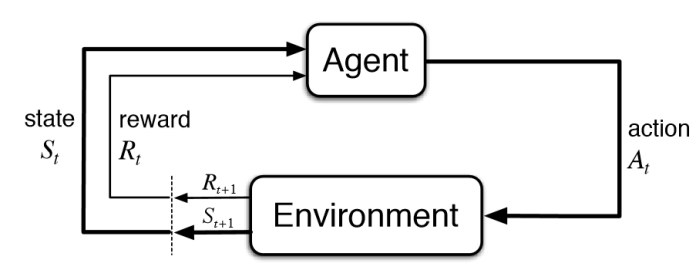

In [6]:
class Environment:
    def __init__(self,length,width):
        self.BOARD_ROWS = length
        self.BOARD_COLS = width
        
    # Setters and Getters to define winning state/location , start state/location and holes in the environment/lake    
    def setWinState(self,x,y):
        self.WIN_STATE = (x,y)
        
    def setStart(self,x,y):
        self.START = (x,y)
        
    def setHoles(self,holesarray):
        self.HOLES = holesarray
        
    def getWinState(self):
        return self.WIN_STATE
    
    def getStart(self):
        return self.START
    
    def getHoles(self):
        return self.HOLES
        
    def getSize(self):
        return self.BOARD_ROWS,self.BOARD_COLS

### Defining Agent


The agent works on the Q learning equation which is defined below:
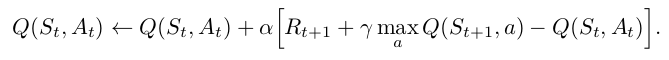

Also, the agent uses epsilon greedy method to deal with exploration-exploitation tradeoff:

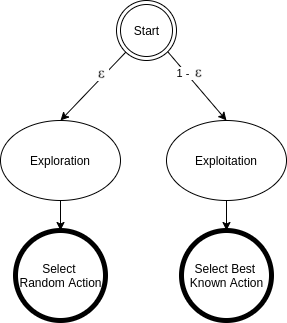

In [14]:
class Agent:
    def __init__(self):
        self.actions = ["up", "down", "left", "right"]                              # Four possible movement for agent
        self.env = Environment(BOARD_ROWS,BOARD_COLS)                               # Defining environment for agent
        self.env.setWinState(WIN_STATE[0],WIN_STATE[1])
        self.env.setStart(START[0],START[1])
        self.env.setHoles(HOLES)
        self.state_size,self.action_size = BOARD_ROWS*BOARD_COLS,len(self.actions)  # Defining state and action space
        self.qtable = np.zeros((self.state_size,self.action_size))                  # Defining Q table for policy learning
        self.rewards = []                                                           # To store rewards per episode
                   
    def printTable(self):
        # Utility fucntion to print Q learning table
        print("------------------- Q LEARNING TABLE ------------------")
        print(self.qtable)
        print("-------------------------------------------------------")
        
    def printPath(self):
        rows,cols = self.env.getSize()
        data = np.ones((rows,cols))*150                                             # Create a matrix to display in heatmap
        for hole in self.env.getHoles():
            data[hole[0],hole[1]] = 300                                             # Mark all the holes to represent in heatmap
        
        START = self.env.getStart()
        state = State(START[0],START[1])      
        while True:
            print("::: ",state.getCoordinates())
            coerd = state.getCoordinates()
            data[coerd[0],coerd[1]] = 50                                            # Mark the movement path to represent in heatmap
            if state.getCoordinates()[0]==self.env.getWinState()[0] and state.getCoordinates()[1]==self.env.getWinState()[1]:
                break
            old_state = state.conversion()
            action = np.argmax(self.qtable[old_state, :])                           # Perform action which gives maximum Q value 
            nextstate = state.nxtCordinates(self.actions[action])                   # Get coordinates of next state
            state = State(nextstate[0],nextstate[1])                                # Update the state for next cycle
                
        hm = sn.heatmap(data = data,linewidths=1,linecolor="black",cmap='Blues',cbar=False)
        plt.show()                                                                  # displaying the plotted heatmap
        
                 
    def q_learning(self):
        # Q-learning, which is said to be an off-policy temporal difference (TD) control algorithm
        START = self.env.getStart()                                                 # reset the environment
        
        for episode in range(total_episodes):
            state = State(START[0],START[1])
            total_rewards = 0                                                       # total reward collected per episode 
            for step in range(max_steps):
                exp_exp_tradeoff = random.uniform(0, 1)                             # First we randomize a number
                old_state  = state.conversion()
        
                if exp_exp_tradeoff > epsilon:                                      # If this number > greater than epsilon --> exploitation (taking the biggest Q value for this state) 
                    action = np.argmax(self.qtable[old_state,:])
                else:                                                               # Else doing a random choice --> exploration
                    action = random.randint(0,len(self.actions)-1)
                           
                nextState = state.nxtCordinates(self.actions[action])
                new_state  = State(nextState[0],nextState[1]).conversion()
                reward = state.getReward()
                total_rewards += reward                                            # Capture reard collected in this step in overall reward of episode
                # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]  :  Q learning equation
                self.qtable[old_state, action] = self.qtable[old_state, action] + learning_rate * (reward + gamma * np.max(self.qtable[new_state, :]) - self.qtable[old_state, action])
                state = State(nextState[0],nextState[1])                           # Update the state
            
            #epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) # Epsilon can be resuce with time to reduce exploration and focus on exploitation
            self.rewards.append(total_rewards)
            
            
    def plotReward(self):
        # Utility function to plot Reward collected wrt to episodes
        plt.figure(figsize=(12,5))
        plt.plot(range(total_episodes),self.rewards,color='red')
        plt.xlabel('Episodes')
        plt.ylabel('Total Reward per Epidode')
        plt.show()

#### Learn Q Values and display them

In [15]:
ag = Agent()
ag.q_learning()
ag.printTable()

------------------- Q LEARNING TABLE ------------------
[[ 32.61625379  33.7513931   32.61625379  37.3513931 ]
 [ 37.3513931   42.612659    32.61625379  42.612659  ]
 [ 36.50233035  48.45851     37.3513931   42.22485186]
 [ 15.47584594  50.93707266  -2.21097188  -2.29187813]
 [ -2.26219063  46.10034375  -2.18453438  -2.26219063]
 [ 28.55093884  38.6116049   29.74702129  38.612659  ]
 [ 37.3513931   48.45851     33.7513931   48.45851   ]
 [ 42.55658871  54.9539      42.60177656  51.35389251]
 [ -5.3875      58.171       38.36354     42.6345    ]
 [ 11.79312187  70.19        24.86445     55.9892888 ]
 [ 33.75137587  36.57684747  41.91148947  48.45851   ]
 [ 42.612659    51.3539      42.612659    54.9539    ]
 [ 48.45851     62.171       48.45851     62.171     ]
 [ 51.3539      70.19        54.9539      70.19      ]
 [ 62.171       79.1         62.171       70.19      ]
 [ 42.61256306   1.40807818  17.73717535  -3.125     ]
 [ 44.45851     54.931       33.29255777  58.171     ]
 [ 54.953

#### Display the learned path by the agent 

:::  (0, 0)
:::  (0, 1)
:::  (1, 1)
:::  (2, 1)
:::  (2, 2)
:::  (3, 2)
:::  (3, 3)
:::  (4, 3)
:::  (4, 4)


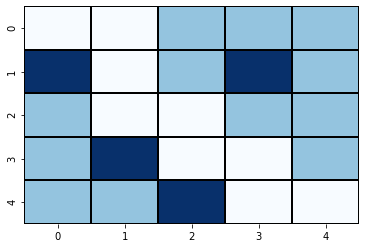

In [16]:
ag.printPath() 
# The below heatmap represent the path of agent to reach destination from source. 
# The dark blue cells represents hole with light blue as ice, the white cell represnts path of agent

#### Plot of Rewards vs Episodes

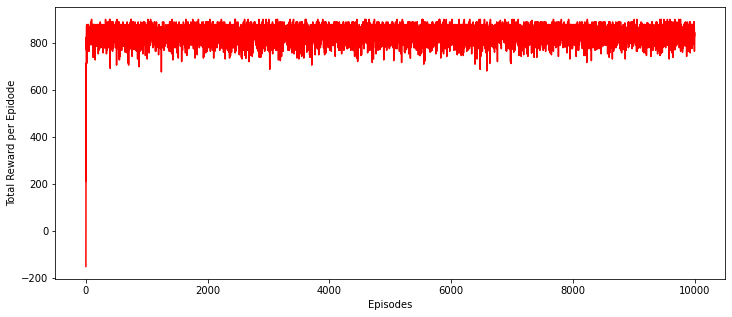

In [17]:
ag.plotReward()

# References: 
    https://www.baeldung.com/cs/epsilon-greedy-q-learning
    https://towardsdatascience.com/reinforcement-learning-temporal-difference-sarsa-q-learning-expected-sarsa-on-python-9fecfda7467e
    https://cwong8.github.io/projects/FrozenLake/
    https://www.kaggle.com/sarjit07/reinforcement-learning-using-q-table-frozenlake
    https://towardsdatascience.com/my-journey-to-reinforcement-learning-part-1-q-learning-with-table-35540020bcf9
    https://cs.stanford.edu/people/karpathy/reinforcejs/gridworld_dp.html

Sample solution for same problem with **bigger space** (Configuration described below):

```
# global variables
BOARD_ROWS = 10
BOARD_COLS = 10
WIN_STATE = (9, 9)
START = (0, 0)
HOLES = [(1,0),(1,1),(2,0),(2,1),(3,1),(3,3),(3,4),(3,5),(4,4),(4,5),(5,5),(1,8),(1,9),(2,8),(2,9),(7,2),(8,2),(9,2),(8,1),(9,1),(7,7),(8,7),(7,8),(8,8),(7,9)]
```

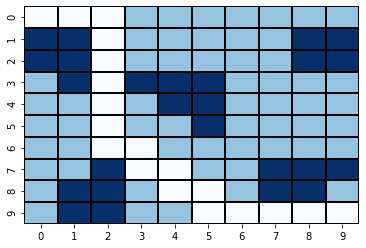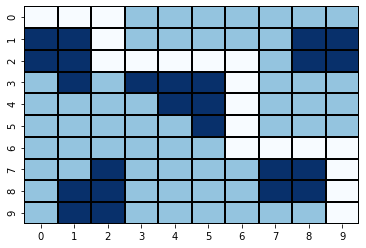 